In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import tree
import graphviz

data_path = 'Stars.csv'

In [2]:
data = pd.read_csv(data_path)
data.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
 6   Type            240 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


In [4]:
# convert categories to the 'category' type
categories = ['Color', 'Spectral_Class', 'Type']
data[categories] = data[categories].astype('category')

In [5]:
# check for null values
data[data.isnull().any(axis=1)].shape[0]

0

In [6]:
data['Color'].value_counts()

Red                   112
Blue                   56
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              4
Yellowish White         3
white                   3
Orange                  2
Whitish                 2
yellowish               2
Blue-White              1
Orange-Red              1
Pale yellow orange      1
White-Yellow            1
Yellowish               1
Name: Color, dtype: int64

In [7]:
def clean_color(color):
    color = color.lower().replace('-', ' ')
    if color == 'yellowish white' or color == 'white yellow':
        color = 'yellow white'
    elif color == 'whitish':
        color = 'white'
    color = color.replace('ish', ' white')
    return color

data['Color'] = data['Color'].apply(lambda x: clean_color(str(x)))
data['Color'].value_counts()

red                   112
blue                   56
blue white             41
yellow white           15
white                  12
orange                  2
pale yellow orange      1
orange red              1
Name: Color, dtype: int64

In [8]:
data['Spectral_Class'].value_counts()

M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: Spectral_Class, dtype: int64

In [9]:
data['Type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: Type, dtype: int64

In [10]:
type_map = {
    0: 'Red Dwarf',
    1: 'Brown Dwarf',
    2: 'White Dwarf',
    3: 'Main Sequence',
    4: 'Super Giant',
    5: 'Hyper Giant',
}

data['Type Name'] = data['Type'].apply(lambda x: type_map[int(x)]).astype('category')
# one_hot = pd.get_dummies(data['Type'])
# data.join(one_hot)

In [11]:
def kruskal_wallis(categorical, numerical):
    samples_by_group = []
    for value in set(data[categorical]):
        mask = data[categorical] == value
        samples_by_group.append(data[numerical][mask])
    stat, p = stats.kruskal(*samples_by_group)
    return stat, p

def box(categorical, numerical, c_name=None, n_name=None, log_scale=False):
    if c_name is None:
        c_name = categorical
        if c_name == 'Type Name':
            c_name = 'Type'
    if n_name is None:
        n_name = numerical

    stat, p = kruskal_wallis(categorical, numerical)
    print('Kruskal-Wallis Test:', stat, p)

    p = sns.boxplot(x=numerical, y=categorical, data=data)
    if log_scale:
        p.set_xscale('log')
    plt.title(f'{n_name} vs {c_name}')
    plt.xlabel(n_name)
    plt.ylabel(c_name)
    plt.show()

Kruskal-Wallis Test: 153.52766268176407 2.368365528517132e-31


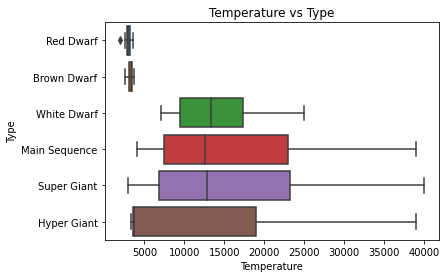

In [12]:
box('Type Name', 'Temperature')

Kruskal-Wallis Test: 206.8652400857501 9.647545008660759e-43


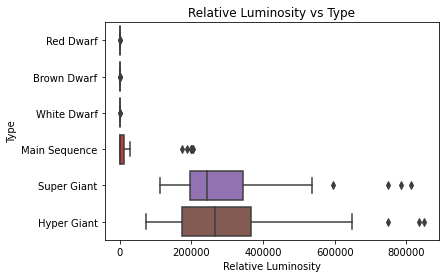

In [13]:
box('Type Name', 'L', n_name='Relative Luminosity')

Kruskal-Wallis Test: 206.8652400857501 9.647545008660759e-43


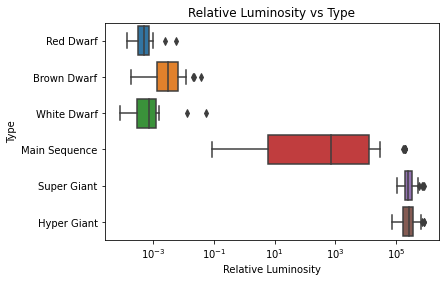

In [14]:
box('Type Name', 'L', n_name='Relative Luminosity', log_scale=True)

Kruskal-Wallis Test: 231.76054519715893 4.485641497787849e-48


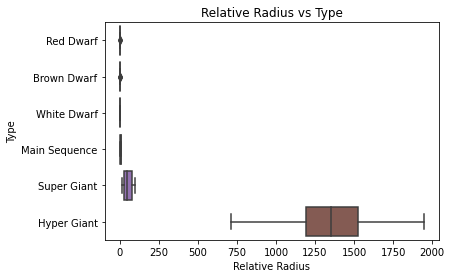

In [15]:
box('Type Name', 'R', n_name='Relative Radius')

Kruskal-Wallis Test: 231.76054519715893 4.485641497787849e-48


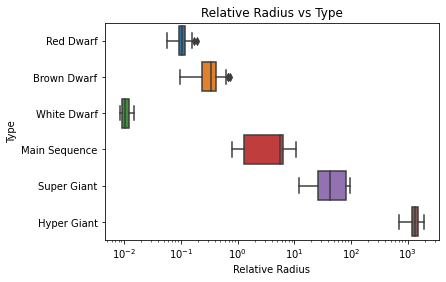

In [16]:
box('Type Name', 'R', n_name='Relative Radius', log_scale=True)

Kruskal-Wallis Test: 225.73068959732555 8.793610581185222e-47


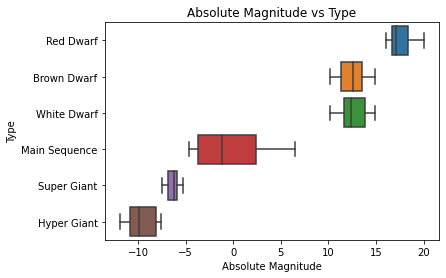

In [17]:
box('Type Name', 'A_M', n_name='Absolute Magnitude')

In [18]:
def heat(cat1, cat2, c1_name=None, c2_name=None):
    if c1_name is None:
        c1_name = cat1
        if c1_name == 'Type Name':
            c1_name = 'Type'
    if c2_name is None:
        c2_name = cat2

    heatData = data[[cat1, cat2]].copy()
    heatData = heatData.groupby([cat1, cat2]).size()
    heatData = heatData.unstack(fill_value=0)
    sns.heatmap(heatData)
    plt.title(f'Counts of {c2_name} vs {c1_name}')
    plt.ylabel(c1_name)
    plt.xlabel(c2_name)

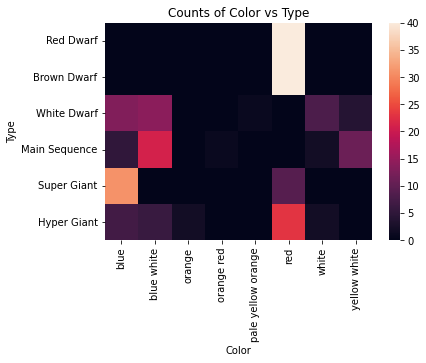

In [19]:
heat('Type Name', 'Color')

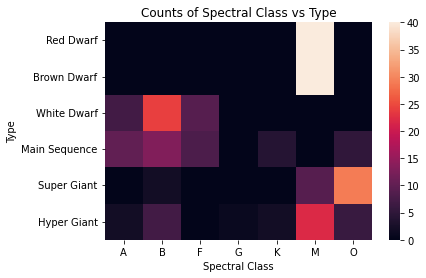

In [20]:
heat('Type Name', 'Spectral_Class', c2_name='Spectral Class')

In [34]:
def get_data_split(features):
    model_x = data[features]
    model_y = data['Type']
    x_train, x_test, y_train, y_test = train_test_split(
            model_x, model_y,
            test_size=0.3,
            stratify=model_y
        )
    return x_train, x_test, y_train, y_test

feature1 = 'R'
feature2 = 'L'
x_train, x_test, y_train, y_test = get_data_split([feature1, feature2])

In [35]:
model = LogisticRegression(
    solver='lbfgs',
    penalty='none',
    multi_class='multinomial',
    tol=0.0001, max_iter=1000,
)
model.fit(x_train, y_train)

def get_metrics(clf):
    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, pred)
    print(f'Accuracy: {accuracy}\nAverage Precision: {np.mean(precision)}\nAverage Recall: {np.mean(recall)}\nAverage F-Score: {np.mean(fscore)}')

get_metrics(model)

Accuracy: 0.3472222222222222
Average Precision: 0.19618279569892474
Average Recall: 0.34722222222222215
Average F-Score: 0.24488940768010536


C:\Users\jankowskig\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1296x1296 with 0 Axes>

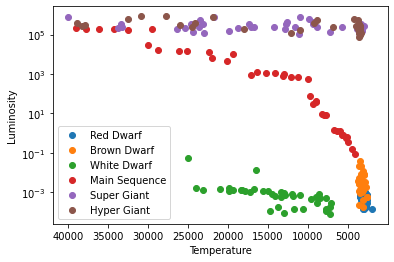

<Figure size 1296x1296 with 0 Axes>

In [29]:
fig, ax = plt.subplots()

# ax.set_xscale('log')
ax.set_yscale('log')
ax.invert_xaxis()

#DecisionBoundaryDisplay.from_estimator( model_tree,
#x_train, response_method='predict', cmap=plt.cm.Paired, ax=ax)
#plt.axis('tight')

types = [type_map[t] for t in type_map]
x = data['Temperature']
y = data['L']
for t in types:
    plt.scatter(
        x[data['Type Name']==t],
        y[data['Type Name']==t]
    )
plt.legend(types)

plt.xlabel('Temperature')
plt.ylabel('Luminosity')
plt.figure(figsize=(18, 18))

In [24]:
feature1 = 'Temperature'
feature2 = 'L'
x_train, x_test, y_train, y_test = get_data_split([feature1, feature2])

In [25]:
model_tree = tree.DecisionTreeClassifier()
model_tree.fit(x_train, y_train)
get_metrics(model_tree)

Accuracy: 0.75
Average Precision: 0.7569264069264069
Average Recall: 0.75
Average F-Score: 0.7508867943650553


In [26]:
"""
dot_data = tree.export_graphviz(
    model_tree,
    out_file=None,
    feature_names=[feature1, feature2],
    class_names=types,
    filled=True, rounded=True,
    special_characters=True
    )
graph = graphviz.Source(dot_data)
graph
"""

'\ndot_data = tree.export_graphviz(\n    model_tree,\n    out_file=None,\n    feature_names=[feature1, feature2],\n    class_names=types,\n    filled=True, rounded=True,\n    special_characters=True\n    )\ngraph = graphviz.Source(dot_data)\ngraph\n'